In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

--------
# Gather data

In [3]:
zbest_path = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/denali/testdenali/All/alltiles_Allzinfo.fits'
zbest_columns = ['TARGETID', 'CHI2', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2', 'PETAL_LOC', 'DEVICE_LOC', 'LOCATION', 'FIBER', 'FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'PMRA', 'PMDEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'GAIA_PHOT_G_MEAN_MAG', 'EBV', 'FLUX_W1', 'FLUX_W2', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_Z', 'MASKBITS', 'SERSIC', 'PHOTSYS', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'TILEID', 'COADD_NUMEXP', 'COADD_EXPTIME', 'EXPS', 'TSNR2_ELG', 'TSNR2_BGS', 'TSNR2_QSO', 'TSNR2_LRG', 'EFFTIME_DARK', 'EFFTIME_BRIGHT', 'EFFTIME_BACK', 'coadd_type', 'TARGETS', 'FIRST_EXPID', 'subset']

tmp = Table(fitsio.read(zbest_path, columns=['SV1_DESI_TARGET', 'TARGETS', 'coadd_type']))
mask = (tmp['SV1_DESI_TARGET'] & 2**0 > 0) & (tmp['TARGETS']=='QSO+LRG') & (tmp['coadd_type']!='pernight')
idx = np.where(mask)[0]

zbest = Table(fitsio.read(zbest_path, columns=zbest_columns, rows=idx))
print(len(zbest))
print(len(np.unique(zbest['TARGETID'])))

581288
52023


In [4]:
deep = zbest.copy()

# Select deep coadds
mask = deep['coadd_type']=='cumulative'
print(np.sum(mask))
# # Select QSO+LRG tiles
# mask &= deep['TARGETS']=='QSO+LRG'
# print(np.sum(mask))
deep = deep[mask]

# Remove FIBERSTATUS!=0 fibers
mask = deep['FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
deep = deep[mask]

# Remove "no data" fibers
mask = deep['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
deep = deep[mask]

# Require a minimum depth for the deep coadd
min_depth = 3000.
mask = deep['EFFTIME_DARK']>min_depth
print('Min depth', np.sum(mask), np.sum(~mask), np.sum(mask)/len(mask))
deep = deep[mask]

# WISE masks
maskbits = [8, 9]
mask_clean = np.ones(len(deep), dtype=bool)
for bit in maskbits:
    mask_clean &= (deep['MASKBITS'] & 2**bit)==0
print('MASKBITS', np.sum(mask_clean), np.sum(~mask_clean), np.sum(mask_clean)/len(mask_clean))
deep = deep[mask_clean]

52268
FIBERSTATUS 43371 8897 0.17021887196755184
No data 43368 3 6.917064397869545e-05
Min depth 31466 11902 0.7255580151263604
MASKBITS 30218 1248 0.9603381427572618


In [5]:
print(len(deep))
print(len(np.unique(deep['TARGETID'])))

deep_columns_old = ['Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2', 'EFFTIME_DARK', 'EFFTIME_BRIGHT', 'EFFTIME_BACK']
deep_columns_new = ['Z_deep', 'ZERR_deep', 'ZWARN_deep', 'SPECTYPE_deep', 'SUBTYPE_deep', 'DELTACHI2_deep', 'EFFTIME_DARK_deep', 'EFFTIME_BRIGHT_deep', 'EFFTIME_BACK_deep']
deep.rename_columns(deep_columns_old, deep_columns_new)

30218
30161


In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    deep['gmag'] = 22.5 - 2.5*np.log10(deep['FLUX_G']) - 3.214 * deep['EBV']
    deep['rmag'] = 22.5 - 2.5*np.log10(deep['FLUX_R']) - 2.165 * deep['EBV']
    deep['zmag'] = 22.5 - 2.5*np.log10(deep['FLUX_Z']) - 1.211 * deep['EBV']
    deep['w1mag'] = 22.5 - 2.5*np.log10(deep['FLUX_W1']) - 0.184 * deep['EBV']
    deep['w2mag'] = 22.5 - 2.5*np.log10(deep['FLUX_W2']) - 0.113 * deep['EBV']
    deep['rfibermag'] = 22.5 - 2.5*np.log10(deep['FIBERFLUX_R']) - 2.165 * deep['EBV']
    deep['zfibermag'] = 22.5 - 2.5*np.log10(deep['FIBERFLUX_Z']) - 1.211 * deep['EBV']

In [7]:
mask = zbest['coadd_type']=='perexp'
zbest = zbest[mask]
print(len(zbest))

zbest['EXPID'] = np.array(np.char.replace(zbest['subset'], 'exp', ''), dtype=int)

mask = np.in1d(zbest['TARGETID'], deep['TARGETID'])
zbest = zbest[mask]
print(len(zbest))

print(len(np.unique(zbest['TARGETID'])))

deep_columns = deep_columns_new+['TARGETID', 'gmag', 'rmag', 'zmag', 'w1mag', 'w2mag', 'rfibermag', 'zfibermag']
zbest = join(zbest, deep[deep_columns], keys='TARGETID')

529020
375540
30161


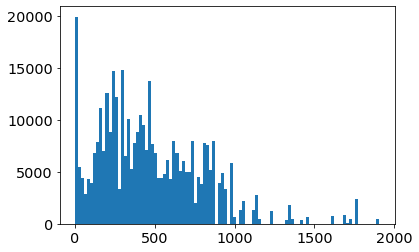

52024 0.1380943280032278


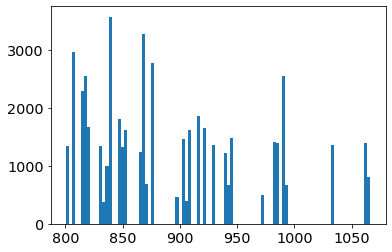

891.3545083707797
868.3665161132812


In [8]:
plt.hist(zbest['EFFTIME_DARK'], 100)
plt.show()

mask = (zbest['EFFTIME_DARK'] > 800) & (zbest['EFFTIME_DARK'] < 1100)
print(np.sum(mask), np.sum(mask)/len(mask))

zbest = zbest[mask]

plt.hist(zbest['EFFTIME_DARK'], 100)
plt.show()

print(np.mean(zbest['EFFTIME_DARK']))
print(np.median(zbest['EFFTIME_DARK']))

--------

In [9]:
# Not repeatable
zdiff_threshold = 0.0033
mask_fail = np.abs((zbest['Z'] - zbest['Z_deep'])/(1 + zbest['Z_deep'])) > zdiff_threshold
print(np.sum(mask_fail), np.sum(mask_fail)/len(mask_fail))
# Also reject objects with ZWARN!=0 or z>1.4 or DELTACHI2<15 in the deep coadds
mask_deep = (zbest['ZWARN_deep']==0) & (zbest['Z_deep']<1.4)
# mask_deep = (zbest['ZWARN_deep']==0) & (zbest['Z_deep']<1.4) & (zbest['DELTACHI2_deep']>30)
mask_fail |= (~mask_deep)
print(np.sum(mask_fail), np.sum(mask_fail)/len(mask_fail))

4508 0.08665231431646932
4776 0.09180378286944488


In [10]:
mask_quality = zbest['ZWARN']==0
mask_quality &= zbest['Z']<1.4
mask_quality &= zbest['DELTACHI2']>15

# Custom DELTACHI2 vs z cut
d = (10**(3 - 3.5*zbest['Z']))
mask_remove = (d>30) & (zbest['DELTACHI2']<30)
mask_remove |= (d<30) & (zbest['DELTACHI2']<d)
mask_remove |= (zbest['DELTACHI2']<10)
mask_quality1 = zbest['ZWARN']==0
mask_quality1 &= zbest['Z']<1.4
mask_quality1 &= (~mask_remove)

-------
# Apply the new LRG selection

In [11]:
gmag = zbest['gmag']
rmag = zbest['rmag']
zmag = zbest['zmag']
w1mag = zbest['w1mag']
w2mag = zbest['w2mag']
rfibermag = zbest['rfibermag']
zfibermag = zbest['zfibermag']
gaia_g = zbest['GAIA_PHOT_G_MEAN_MAG']

mask_north = zbest['PHOTSYS']=='N'
mask_south = zbest['PHOTSYS']=='S'

In [12]:
# mask_north = zbest['PHOTSYS']=='N'
# mask_south = zbest['PHOTSYS']=='S'

# South
lrg_mask = mask_south.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.6)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.14) * 1.8  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.33) * 1.  # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.3
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.9  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

mask_bright = (gaia_g!=0) & (gaia_g < 18)
lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_new_south = lrg_mask.copy()

# North
lrg_mask = mask_north.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.61)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.13) * 1.83  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.31) * 1.   # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.4
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.97  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

mask_bright = (gaia_g!=0) & (gaia_g < 18)
lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_new_north = lrg_mask.copy()

lrg_new = lrg_new_south | lrg_new_north
print(np.sum(lrg_new))

14457


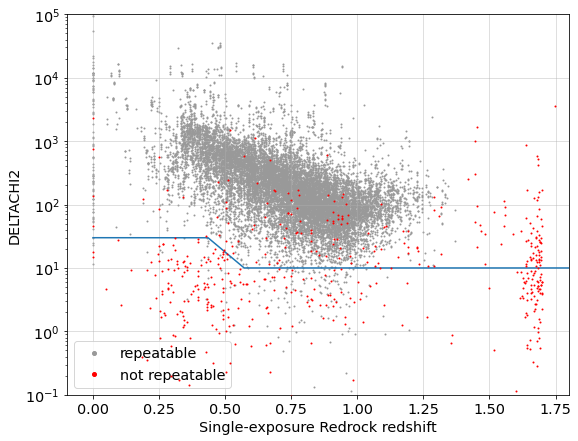

In [13]:
x = np.linspace(0, 2, 10000)
y = np.ones_like(x)
y = (10**(3 - 3.5*x))
y[y<10] = 10
y[y>30] = 30

plt.figure(figsize=(9, 7))
plt.plot(zbest['Z'][lrg_new & (~mask_fail)], zbest['DELTACHI2'][lrg_new & (~mask_fail)], '.', color='0.6', ms=2, alpha=1, label='repeatable', zorder=1)
plt.plot(zbest['Z'][lrg_new & mask_fail], zbest['DELTACHI2'][lrg_new & mask_fail], 'r.', ms=2, alpha=1, label='not repeatable', zorder=10)
plt.plot(x, y)
# plt.axhline(9., ls='--', color='0.6', label='ZWARN threshold')
plt.yscale('log')
plt.xlabel('Single-exposure Redrock redshift')
plt.ylabel('DELTACHI2')
plt.axis([-0.1, 1.8, .1, 100000])
plt.legend(markerscale=4, loc='lower left')
plt.grid(alpha=0.5)
plt.show()

In [14]:
print('Catastrophic failures before the quality cuts:')
print('{:.1f}% ({}/{})'.format(np.sum(lrg_new & mask_fail)/np.sum(lrg_new)*100, np.sum(lrg_new & mask_fail), np.sum(lrg_new)))
print()

print('DELTACHI2 > 15')
print('Fraction removed: {:.1f}% ({}/{})'.format(np.sum((~mask_quality) & lrg_new)/np.sum(lrg_new)*100, np.sum((~mask_quality) & lrg_new), np.sum(lrg_new)))
print('Remaining catastrophic failures: {:.1f}% ({}/{})'.format(np.sum(mask_quality & lrg_new & mask_fail)/np.sum(mask_quality & lrg_new)*100, np.sum(mask_quality & lrg_new & mask_fail), np.sum(mask_quality & lrg_new)))
print()

print('Custom DELTACHI2 cut')
print('Fraction removed: {:.1f}% ({}/{})'.format(np.sum((~mask_quality1) & lrg_new)/np.sum(lrg_new)*100, np.sum((~mask_quality1) & lrg_new), np.sum(lrg_new)))
print('Remaining catastrophic failures: {:.1f}% ({}/{})'.format(np.sum(mask_quality1 & lrg_new & mask_fail)/np.sum(mask_quality1 & lrg_new)*100, np.sum(mask_quality1 & lrg_new & mask_fail), np.sum(mask_quality1 & lrg_new)))

Catastrophic failures before the quality cuts:
3.3% (483/14457)

DELTACHI2 > 15
Fraction removed: 4.3% (615/14457)
Remaining catastrophic failures: 0.9% (119/13842)

Custom DELTACHI2 cut
Fraction removed: 3.5% (511/14457)
Remaining catastrophic failures: 0.8% (116/13946)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]


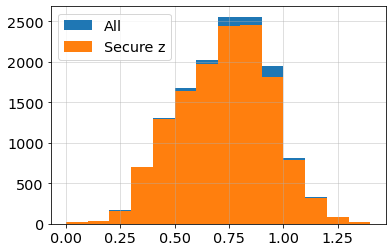

In [32]:
mask_star = (zbest['SPECTYPE']=='STAR') | (zbest['Z']<0.0003)

bins = np.arange(0., 1.45, 0.1)
bin_centers = (bins[1:]+bins[:-1])/2
print(bins)

plt.hist(zbest['Z_deep'][lrg_new & (~mask_star)], bins=bins, alpha=1, label='All')
plt.hist(zbest['Z_deep'][lrg_new & mask_quality & (~mask_star)], bins=bins, alpha=1, label='Secure z')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

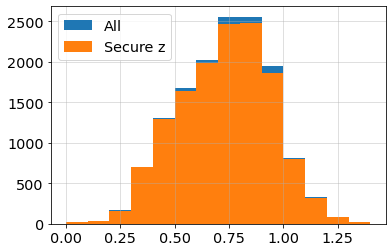

In [33]:
# Custom DELTACHI2 vs z cut 
plt.hist(zbest['Z_deep'][lrg_new & (~mask_star)], bins=bins, alpha=1, label='All')
plt.hist(zbest['Z_deep'][lrg_new & mask_quality1 & (~mask_star)], bins=bins, alpha=1, label='Secure z')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

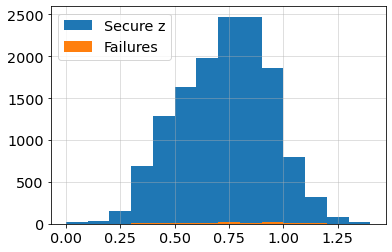

In [40]:
plt.hist(zbest['Z_deep'][lrg_new & mask_quality1 & (~mask_star)], bins=bins, alpha=1, label='Secure z')
plt.hist(zbest['Z_deep'][lrg_new & mask_quality1 & (~mask_star) & mask_fail], bins=bins, alpha=1, label='Failures')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [98]:
bins = np.round(np.arange(0.3, 1.4, 0.1), 2)
bin_centers = (bins[1:]+bins[:-1])/2
print(bins)

[0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3]


__Completeness__

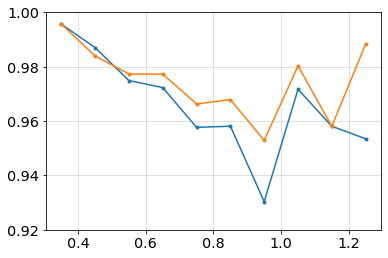

In [99]:
hist_all, _ = np.histogram(zbest['Z_deep'][lrg_new & (~mask_star)], bins=bins)
hist_secure, _ = np.histogram(zbest['Z_deep'][lrg_new & mask_quality & (~mask_star)], bins=bins)
hist_secure1, _ = np.histogram(zbest['Z_deep'][lrg_new & mask_quality1 & (~mask_star)], bins=bins)
hist_fail1, _ = np.histogram(zbest['Z_deep'][lrg_new & mask_quality1 & (~mask_star) & mask_fail], bins=bins)

plt.plot(bin_centers, hist_secure/hist_all, '.-')
plt.plot(bin_centers, hist_secure1/hist_all, '.-')
plt.grid(alpha=0.5)
plt.ylim(0.92, 1)
plt.show()

In [104]:
t = Table()
t['zmin'] = bins[:-1]
t['zmax'] = bins[1:]
t['N_all'] = hist_all
t['N_secure'] = hist_secure
t['N_secure1'] = hist_secure1
t['comp_frac'] = hist_secure/hist_all
t['comp_frac1'] = hist_secure1/hist_all
print(np.sum(t['N_all']))
t.write('completeness_vs_redshift.txt', format='ascii.commented_header')
t

14000


zmin,zmax,N_all,N_secure,N_secure1,comp_frac,comp_frac1
float64,float64,int64,int64,int64,float64,float64
0.3,0.4,698,695,695,0.995702005730659,0.995702005730659
0.4,0.5,1310,1293,1289,0.9870229007633587,0.983969465648855
0.5,0.6,1675,1633,1637,0.9749253731343284,0.977313432835821
0.6,0.7,2024,1968,1978,0.9723320158102767,0.9772727272727273
0.7,0.8,2552,2444,2466,0.957680250783699,0.9663009404388715
0.8,0.9,2555,2448,2473,0.9581213307240705,0.9679060665362035
0.9,1.0,1953,1817,1861,0.9303635432667691,0.9528929851510497
1.0,1.1,813,790,797,0.971709717097171,0.980319803198032
1.1,1.2,334,320,320,0.9580838323353293,0.9580838323353293


__Remaining catastrophic failures__

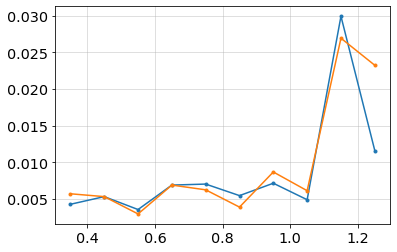

In [101]:
hist_all, _ = np.histogram(zbest['Z_deep'][lrg_new & (~mask_star)], bins=bins)
hist_secure, _ = np.histogram(zbest['Z_deep'][lrg_new & mask_quality & (~mask_star)], bins=bins)
hist_secure1, _ = np.histogram(zbest['Z_deep'][lrg_new & mask_quality1 & (~mask_star)], bins=bins)
hist_fail, _ = np.histogram(zbest['Z_deep'][lrg_new & mask_quality & (~mask_star) & mask_fail], bins=bins)
hist_fail1, _ = np.histogram(zbest['Z_deep'][lrg_new & mask_quality1 & (~mask_star) & mask_fail], bins=bins)

plt.plot(bin_centers, hist_fail/hist_all, '.-')
plt.plot(bin_centers, hist_fail1/hist_all, '.-')
plt.grid(alpha=0.5)
plt.show()

__Catastrophic failures before quality cuts__

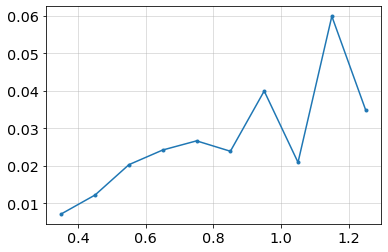

In [102]:
hist_all, _ = np.histogram(zbest['Z_deep'][lrg_new & (~mask_star)], bins=bins)
hist_fail, _ = np.histogram(zbest['Z_deep'][lrg_new  & (~mask_star) & mask_fail], bins=bins)

plt.plot(bin_centers, hist_fail/hist_all, '.-')
plt.grid(alpha=0.5)
plt.show()